In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np
from scipy.misc import imread
from scipy.misc import imresize
from scipy.misc import imsave
import glob
import random

from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
#from keras.applications.resnet50 import preprocess_input

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
#from keras.applications.vgg19 import preprocess_input as preprocess_vgg
from keras.applications.inception_v3 import preprocess_input as inception_preprocess

#from keras.applications.inception_resnet_v2 import preprocess_input

import numpy as np

import keras
import copy
import cv2

from keras.models import *
from keras.layers import *
from keras.optimizers import *

import numpy as np 
import os
import numpy as np
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

Using TensorFlow backend.


In [2]:
path = '../data/nparrs/'
savepath = '../data/'
images = glob.glob(path+'*.npy')
totalImages = 1800

In [3]:
def myGenerator(batch_size):
    while True:
        index_list = random.sample(range(1, totalImages), batch_size)
        alldata_x = []
        alldata_y = []
        for i in index_list:
            frame = images[i]
            frame = np.load(frame)
            tile_index = np.random.randint(0, 199)
            #print(i, tile_index, frame.shape)
            alldata_x.append(tile_index*totalImages+i)
            alldata_y.append(frame[tile_index])
        alldata_x = np.array(alldata_x)
        alldata_y = np.array(alldata_y)
        alldata_y = (alldata_y.astype(np.float32) - 127.5) / 127.5
        yield alldata_y, alldata_y
#x = myGenerator()
#xtrain, ytrain = next(x)
#print('xtrain shape:',xtrain.shape)
#print('ytrain shape:',ytrain.shape)

In [9]:
class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 192
        self.img_cols = 192
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        #self.discriminator = self.build_discriminator()
        #self.discriminator.compile(loss=['mse'],
        #    optimizer=optimizer,
        #    metrics=['accuracy'])
        
        #print(self.discriminator.summary())
        
        # Build the generator
        self.generator = self.build_generator()
        
        print(self.generator.summary())
        
        noise = Input(shape=(192, 192, 3))
        img = self.generator(noise)

        # For the combined model we will only train the generator
        #self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        #valid = self.discriminator(img)
        
        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        #self.combined = Model(noise, [img, valid])
        #self.combined.compile(loss=['mse', 'mse'],
        #    loss_weights=[0.9, 0.1],
        #    optimizer=optimizer)

    def build_generator(self):
        #Encoder
        input_size = (192,192,3)
        inputs = Input(input_size)


        conv1 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv1 = LeakyReLU(alpha=0.2)(conv1)
        conv1 = BatchNormalization(momentum=0.8)(conv1)

        conv1 = Conv2D(64, 3, padding = 'valid', kernel_initializer = 'he_normal')(conv1)
        conv1 = LeakyReLU(alpha=0.2)(conv1)
        conv1 = BatchNormalization(momentum=0.8)(conv1)

        pool1 = Conv2D(64, 3, subsample=(2, 2), kernel_initializer = 'he_normal')(conv1)
        pool1 = LeakyReLU(alpha=0.2)(pool1)
        pool1 = BatchNormalization(momentum=0.8)(pool1)




        conv2 = Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = LeakyReLU(alpha=0.2)(conv2)
        conv2 = BatchNormalization(momentum=0.8)(conv2)

        conv2 = Conv2D(256, 3, padding = 'valid', kernel_initializer = 'he_normal')(conv2)
        conv2 = LeakyReLU(alpha=0.2)(conv2)
        conv2 = BatchNormalization(momentum=0.8)(conv2)

        pool2 = Conv2D(256, 3, subsample=(2, 2), kernel_initializer = 'he_normal')(conv2)
        pool2 = LeakyReLU(alpha=0.2)(pool2)
        pool2 = BatchNormalization(momentum=0.8)(pool2)




        conv3 = Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = LeakyReLU(alpha=0.2)(conv3)
        conv3 = BatchNormalization(momentum=0.8)(conv3)

        conv3 = Conv2D(1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv3)
        conv3 = LeakyReLU(alpha=0.2)(conv3)
        conv3 = BatchNormalization(momentum=0.8)(conv3)




        #Decoder
        up1    = UpSampling2D(size = (2,2))(conv3)
        up1    = ZeroPadding2D(padding=(1, 1))(up1)


        conv4 = Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(up1)
        conv4 = LeakyReLU(alpha=0.2)(conv4)
        conv4 = BatchNormalization(momentum=0.8)(conv4)

        merge1 = concatenate([conv4, conv2], axis = 3)

        conv5 = Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(merge1)
        conv5 = LeakyReLU(alpha=0.2)(conv5)
        conv5 = BatchNormalization(momentum=0.8)(conv5)

        conv5 = Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
        conv5 = LeakyReLU(alpha=0.2)(conv5)
        conv5 = BatchNormalization(momentum=0.8)(conv5)


        up2    = UpSampling2D(size = (2,2))(conv5)
        up2    = ZeroPadding2D(padding=(3, 3))(up2)


        conv6 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(up2)
        conv6 = LeakyReLU(alpha=0.2)(conv6)
        conv6 = BatchNormalization(momentum=0.8)(conv6)


        merge2 = concatenate([conv6, conv1], axis = 3)
        merge2 = ZeroPadding2D(padding=(1, 1))(merge2)

        conv7 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(merge2)
        conv7 = LeakyReLU(alpha=0.2)(conv7)
        conv7 = BatchNormalization(momentum=0.8)(conv7)

        conv8 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv7)
        conv8 = LeakyReLU(alpha=0.2)(conv8)
        conv8 = BatchNormalization(momentum=0.8)(conv8)
        
        conv9 = Conv2D(3, 1, padding = 'same', kernel_initializer = 'he_normal', activation='tanh')(conv8)
        
        model = Model(input = inputs, output = conv9)
        return model
    
    def build_autoencoder(self):
        self.generator.compile(loss=['mse'],optimizer=self.optimizer)
    
    def train_generator_autoencoder(self, epochs, batch_size=128, sample_interval=10):
        for epoch in range(epochs):
            X_train, y_train = next(myGenerator(batch_size))
            g_loss = self.generator.train_on_batch(X_train, X_train)
            print ("Epoch ", epoch, " G loss ", g_loss)
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                self.generator.save_weights(savepath+'weights/generator_weights_'+str(epoch)+'.h5')
            
    def build_discriminator(self):
        img   = Input(shape=(192, 192, 3))
        
        model = Sequential()
        model.add(Conv2D(64, (3, 3), input_shape=(192, 192, 3)))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64,  (3, 3),  strides=(2, 2)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64, (3, 3)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64, (6, 6),  strides=(2, 2)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64, (3, 3),  strides=(2, 2)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        
        model.add(Dense(100))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(32))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1))
        
        output    = model(img)
        
        model3 = Model(img, output)
        return model3

    def train(self, epochs, batch_size=128, sample_interval=50):
        random.seed(10)
        
        # Load the dataset
        for epoch in range(epochs):
            X_train, y_train = next(myGenerator(batch_size))
            
            # Adversarial ground truths
            valid = np.ones((batch_size, 1))
            fake  = np.zeros((batch_size, 1))
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            # Generate a half batch of new images
            gen_imgs = self.generator.predict(X_train)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(X_train, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = self.combined.train_on_batch(X_train, [X_train, valid])

            # Plot the progress
            print ("%d [D loss: %f, mean_acc: %.2f%% real_acc: %.2f%% fake_acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss[0], g_loss[1]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                self.generator.save_weights(savepath+'weights/generator_weights_'+str(epoch)+'.h5')
                self.discriminator.save_weights(savepath+'weights/discriminator_weights_'+str(epoch)+'.h5')

    def sample_images(self, epoch):
        r, c             = 1, 10
        X_train, y_train = next(myGenerator(10))
        gen_imgs         = self.generator.predict(X_train)
        
        # Rescale images 0 - 1
        temp     = (0.5 * gen_imgs + 0.5)*255
        gen_imgs = temp.astype(int)
        
        combined = np.array([gen_imgs[0], gen_imgs[1], gen_imgs[2], gen_imgs[3], gen_imgs[4], gen_imgs[5], gen_imgs[6], gen_imgs[7], gen_imgs[8], gen_imgs[9]])
        combined = np.hstack(combined.reshape(10, 192,192, 3))
        imsave(savepath+"images/"+str(epoch)+".png", combined)

In [ ]:
cgan = CGAN()
cgan.build_autoencoder()
cgan.train_generator_autoencoder(1000000, 8, 100)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, 3, kernel_initializer="he_normal", strides=(2, 2))`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:69: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, 3, kernel_initializer="he_normal", strides=(2, 2))`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:129: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 192, 192, 3)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 192, 192, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, 192, 192, 64) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 192, 192, 64) 256         leaky_re_lu_15[0][0]             
__________________________________________________________________________________________________
conv2d_17 

Epoch  0  G loss  1.32112


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:231: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Epoch  1  G loss  0.6861763
Epoch  2  G loss  0.46216702
Epoch  3  G loss  0.3827493
Epoch  4  G loss  0.21945548
Epoch  5  G loss  0.1429605
Epoch  6  G loss  0.14739206
Epoch  7  G loss  0.2131261
Epoch  8  G loss  0.12183998
Epoch  9  G loss  0.15741454
Epoch  10  G loss  0.18098599
Epoch  11  G loss  0.08948605
Epoch  12  G loss  0.15685374
Epoch  13  G loss  0.22708645
Epoch  14  G loss  0.1729711
Epoch  15  G loss  0.15398139
Epoch  16  G loss  0.10502228
Epoch  17  G loss  0.113642216
Epoch  18  G loss  0.14719419
Epoch  19  G loss  0.10098876
Epoch  20  G loss  0.13034971
Epoch  21  G loss  0.15155533
Epoch  22  G loss  0.124009795
Epoch  23  G loss  0.2246637
Epoch  24  G loss  0.15680632
Epoch  25  G loss  0.09819038
Epoch  26  G loss  0.20003524
Epoch  27  G loss  0.15240733
Epoch  28  G loss  0.4388007
Epoch  29  G loss  0.07132947
Epoch  30  G loss  0.092914775
Epoch  31  G loss  0.10598306
Epoch  32  G loss  0.2454934
Epoch  33  G loss  0.080203
Epoch  34  G loss  0.08671

Epoch  265  G loss  0.01780437
Epoch  266  G loss  0.01444194
Epoch  267  G loss  0.016164364
Epoch  268  G loss  0.02455394
Epoch  269  G loss  0.031290535
Epoch  270  G loss  0.028288515
Epoch  271  G loss  0.025688063
Epoch  272  G loss  0.033526007
Epoch  273  G loss  0.02480125
Epoch  274  G loss  0.023839079
Epoch  275  G loss  0.015662499
Epoch  276  G loss  0.051461875
Epoch  277  G loss  0.034800008
Epoch  278  G loss  0.038617995
Epoch  279  G loss  0.039393865
Epoch  280  G loss  0.019167565
Epoch  281  G loss  0.016139444
Epoch  282  G loss  0.069389015
Epoch  283  G loss  0.010175458
Epoch  284  G loss  0.008567575
Epoch  285  G loss  0.09494535
Epoch  286  G loss  0.020830605
Epoch  287  G loss  0.028974148
Epoch  288  G loss  0.012117113
Epoch  289  G loss  0.029296247
Epoch  290  G loss  0.014622651
Epoch  291  G loss  0.018911088
Epoch  292  G loss  0.031498063
Epoch  293  G loss  0.048267268
Epoch  294  G loss  0.019961916
Epoch  295  G loss  0.029978514
Epoch  296  G

Epoch  524  G loss  0.02512625
Epoch  525  G loss  0.014521896
Epoch  526  G loss  0.016914757
Epoch  527  G loss  0.020497859
Epoch  528  G loss  0.014611956
Epoch  529  G loss  0.012417993
Epoch  530  G loss  0.029864088
Epoch  531  G loss  0.012861549
Epoch  532  G loss  0.013914926
Epoch  533  G loss  0.046239745
Epoch  534  G loss  0.042657677
Epoch  535  G loss  0.013480897
Epoch  536  G loss  0.009104854
Epoch  537  G loss  0.021289896
Epoch  538  G loss  0.013338033
Epoch  539  G loss  0.02775984
Epoch  540  G loss  0.012489521
Epoch  541  G loss  0.013645571
Epoch  542  G loss  0.022142418
Epoch  543  G loss  0.023527108
Epoch  544  G loss  0.011278236
Epoch  545  G loss  0.045517832
Epoch  546  G loss  0.021006789
Epoch  547  G loss  0.018604137
Epoch  548  G loss  0.036866874
Epoch  549  G loss  0.0071549937
Epoch  550  G loss  0.039276548
Epoch  551  G loss  0.0135651
Epoch  552  G loss  0.011763335
Epoch  553  G loss  0.023958515
Epoch  554  G loss  0.028107062
Epoch  555 

Epoch  781  G loss  0.012258013
Epoch  782  G loss  0.01144179
Epoch  783  G loss  0.010188654
Epoch  784  G loss  0.045529753
Epoch  785  G loss  0.010899013
Epoch  786  G loss  0.0060468586
Epoch  787  G loss  0.017184757
Epoch  788  G loss  0.0082904305
Epoch  789  G loss  0.026388576
Epoch  790  G loss  0.013052213
Epoch  791  G loss  0.033789333
Epoch  792  G loss  0.02089807
Epoch  793  G loss  0.012261021
Epoch  794  G loss  0.0057758987
Epoch  795  G loss  0.026062792
Epoch  796  G loss  0.03265379
Epoch  797  G loss  0.012201504
Epoch  798  G loss  0.008489545
Epoch  799  G loss  0.07408151
Epoch  800  G loss  0.0126084415
Epoch  801  G loss  0.027430268
Epoch  802  G loss  0.029471738
Epoch  803  G loss  0.016970553
Epoch  804  G loss  0.015853923
Epoch  805  G loss  0.022519596
Epoch  806  G loss  0.011559449
Epoch  807  G loss  0.01721588
Epoch  808  G loss  0.0079301065
Epoch  809  G loss  0.008815457
Epoch  810  G loss  0.02397828
Epoch  811  G loss  0.030738521
Epoch  81

Epoch  1038  G loss  0.00708484
Epoch  1039  G loss  0.017310452
Epoch  1040  G loss  0.014996601
Epoch  1041  G loss  0.017082807
Epoch  1042  G loss  0.011280518
Epoch  1043  G loss  0.013125576
Epoch  1044  G loss  0.0073413635
Epoch  1045  G loss  0.009349126
Epoch  1046  G loss  0.0072393483
Epoch  1047  G loss  0.009647106
Epoch  1048  G loss  0.01461372
Epoch  1049  G loss  0.047640212
Epoch  1050  G loss  0.006532543
Epoch  1051  G loss  0.022096956
Epoch  1052  G loss  0.008507414
Epoch  1053  G loss  0.007421245
Epoch  1054  G loss  0.011351717
Epoch  1055  G loss  0.0030236715
Epoch  1056  G loss  0.010202476
Epoch  1057  G loss  0.006522945
Epoch  1058  G loss  0.013466959
Epoch  1059  G loss  0.010317819
Epoch  1060  G loss  0.009302943
Epoch  1061  G loss  0.013355815
Epoch  1062  G loss  0.0064231562
Epoch  1063  G loss  0.008266353
Epoch  1064  G loss  0.012503873
Epoch  1065  G loss  0.064901225
Epoch  1066  G loss  0.0031163993
Epoch  1067  G loss  0.021557322
Epoch  

Epoch  1287  G loss  0.01642898
Epoch  1288  G loss  0.008210379
Epoch  1289  G loss  0.02107845
Epoch  1290  G loss  0.008931237
Epoch  1291  G loss  0.016091816
Epoch  1292  G loss  0.017736895
Epoch  1293  G loss  0.019738229
Epoch  1294  G loss  0.010614807
Epoch  1295  G loss  0.009641167
Epoch  1296  G loss  0.01631517
Epoch  1297  G loss  0.015839286
Epoch  1298  G loss  0.011603897
Epoch  1299  G loss  0.010672286
Epoch  1300  G loss  0.005591628
Epoch  1301  G loss  0.015823659
Epoch  1302  G loss  0.01361227
Epoch  1303  G loss  0.11855572
Epoch  1304  G loss  0.017629154
Epoch  1305  G loss  0.019882424
Epoch  1306  G loss  0.014399983
Epoch  1307  G loss  0.008602619
Epoch  1308  G loss  0.011941312
Epoch  1309  G loss  0.027105607
Epoch  1310  G loss  0.015944738
Epoch  1311  G loss  0.010659479
Epoch  1312  G loss  0.016582381
Epoch  1313  G loss  0.014894847
Epoch  1314  G loss  0.0074119745
Epoch  1315  G loss  0.023142137
Epoch  1316  G loss  0.02597367
Epoch  1317  G 

Epoch  1536  G loss  0.01246151
Epoch  1537  G loss  0.008289375
Epoch  1538  G loss  0.009485033
Epoch  1539  G loss  0.010793337
Epoch  1540  G loss  0.058286484
Epoch  1541  G loss  0.01263782
Epoch  1542  G loss  0.028348802
Epoch  1543  G loss  0.019240845
Epoch  1544  G loss  0.018248927
Epoch  1545  G loss  0.22961724
Epoch  1546  G loss  0.07897404
Epoch  1547  G loss  0.020210106
Epoch  1548  G loss  0.010953207
Epoch  1549  G loss  0.021016032
Epoch  1550  G loss  0.0071254396
Epoch  1551  G loss  0.02335411
Epoch  1552  G loss  0.009127617
Epoch  1553  G loss  0.035389036
Epoch  1554  G loss  0.009333104
Epoch  1555  G loss  0.03471034
Epoch  1556  G loss  0.044048525
Epoch  1557  G loss  0.038085982
Epoch  1558  G loss  0.014356783
Epoch  1559  G loss  0.015319276
Epoch  1560  G loss  0.030468382
Epoch  1561  G loss  0.020729342
Epoch  1562  G loss  0.018703597
Epoch  1563  G loss  0.035519395
Epoch  1564  G loss  0.005863238
Epoch  1565  G loss  0.0069300854
Epoch  1566  G

Epoch  1785  G loss  0.0071812337
Epoch  1786  G loss  0.012426728
Epoch  1787  G loss  0.006401331
Epoch  1788  G loss  0.008463195
Epoch  1789  G loss  0.016918901
Epoch  1790  G loss  0.015359335
Epoch  1791  G loss  0.039300874
Epoch  1792  G loss  0.004261683
Epoch  1793  G loss  0.031302534
Epoch  1794  G loss  0.014319202
Epoch  1795  G loss  0.030724393
Epoch  1796  G loss  0.00855894
Epoch  1797  G loss  0.020558614
Epoch  1798  G loss  0.0077343835
Epoch  1799  G loss  0.0031794505
Epoch  1800  G loss  0.0034962287
Epoch  1801  G loss  0.0076318355
Epoch  1802  G loss  0.0455299
Epoch  1803  G loss  0.010672759
Epoch  1804  G loss  0.01575439
Epoch  1805  G loss  0.07702918
Epoch  1806  G loss  0.011173185
Epoch  1807  G loss  0.0147811845
Epoch  1808  G loss  0.012390554
Epoch  1809  G loss  0.026581433
Epoch  1810  G loss  0.007588277
Epoch  1811  G loss  0.013523378
Epoch  1812  G loss  0.012509161
Epoch  1813  G loss  0.007784561
Epoch  1814  G loss  0.009273407
Epoch  18

Epoch  2033  G loss  0.009005407
Epoch  2034  G loss  0.0059387702
Epoch  2035  G loss  0.004032513
Epoch  2036  G loss  0.026075585
Epoch  2037  G loss  0.0078662215
Epoch  2038  G loss  0.010289484
Epoch  2039  G loss  0.005186989
Epoch  2040  G loss  0.003864519
Epoch  2041  G loss  0.016444506
Epoch  2042  G loss  0.013247292
Epoch  2043  G loss  0.00560789
Epoch  2044  G loss  0.014890997
Epoch  2045  G loss  0.009067979
Epoch  2046  G loss  0.03873265
Epoch  2047  G loss  0.0063592456
Epoch  2048  G loss  0.030412681
Epoch  2049  G loss  0.0076784743
Epoch  2050  G loss  0.025683943
Epoch  2051  G loss  0.019026706
Epoch  2052  G loss  0.019542474
Epoch  2053  G loss  0.016946876
Epoch  2054  G loss  0.02342227
Epoch  2055  G loss  0.011520807
Epoch  2056  G loss  0.008240189
Epoch  2057  G loss  0.008754345
Epoch  2058  G loss  0.010792758
Epoch  2059  G loss  0.0060180677
Epoch  2060  G loss  0.02810365
Epoch  2061  G loss  0.020244393
Epoch  2062  G loss  0.006757355
Epoch  20

Epoch  2281  G loss  0.005538207
Epoch  2282  G loss  0.026460085
Epoch  2283  G loss  0.012648821
Epoch  2284  G loss  0.0049700616
Epoch  2285  G loss  0.007964993
Epoch  2286  G loss  0.008569706
Epoch  2287  G loss  0.0078739375
Epoch  2288  G loss  0.014152389
Epoch  2289  G loss  0.0064763892
Epoch  2290  G loss  0.051339943
Epoch  2291  G loss  0.008318265
Epoch  2292  G loss  0.021951564
Epoch  2293  G loss  0.0181413
Epoch  2294  G loss  0.009921456
Epoch  2295  G loss  0.0034773583
Epoch  2296  G loss  0.0056849895
Epoch  2297  G loss  0.023097938
Epoch  2298  G loss  0.01532114
Epoch  2299  G loss  0.009623451
Epoch  2300  G loss  0.005329851
Epoch  2301  G loss  0.021160088
Epoch  2302  G loss  0.005873588
Epoch  2303  G loss  0.010188073
Epoch  2304  G loss  0.00795004
Epoch  2305  G loss  0.0075495346
Epoch  2306  G loss  0.007880783
Epoch  2307  G loss  0.016184013
Epoch  2308  G loss  0.0153444735
Epoch  2309  G loss  0.009450765
Epoch  2310  G loss  0.018347824
Epoch  

Epoch  2529  G loss  0.007567048
Epoch  2530  G loss  0.011836702
Epoch  2531  G loss  0.010651399
Epoch  2532  G loss  0.0061696596
Epoch  2533  G loss  0.016315347
Epoch  2534  G loss  0.0035901605
Epoch  2535  G loss  0.019361023
Epoch  2536  G loss  0.019525416
Epoch  2537  G loss  0.016910244
Epoch  2538  G loss  0.0061298045
Epoch  2539  G loss  0.0048707593
Epoch  2540  G loss  0.0050074356
Epoch  2541  G loss  0.027330805
Epoch  2542  G loss  0.0036476755
Epoch  2543  G loss  0.038764246
Epoch  2544  G loss  0.039076447
Epoch  2545  G loss  0.011944739
Epoch  2546  G loss  0.016066898
Epoch  2547  G loss  0.015658684
Epoch  2548  G loss  0.0061121574
Epoch  2549  G loss  0.019638821
Epoch  2550  G loss  0.008887653
Epoch  2551  G loss  0.006383772
Epoch  2552  G loss  0.007834418
Epoch  2553  G loss  0.0099474685
Epoch  2554  G loss  0.004035085
Epoch  2555  G loss  0.007380825
Epoch  2556  G loss  0.00605098
Epoch  2557  G loss  0.01181209
Epoch  2558  G loss  0.006949323
Epoc

Epoch  2777  G loss  0.0051632
Epoch  2778  G loss  0.0022755503
Epoch  2779  G loss  0.0073137553
Epoch  2780  G loss  0.0028709983
Epoch  2781  G loss  0.013306856
Epoch  2782  G loss  0.003415956
Epoch  2783  G loss  0.014809342
Epoch  2784  G loss  0.0035458286
Epoch  2785  G loss  0.007973028
Epoch  2786  G loss  0.0054426296
Epoch  2787  G loss  0.008128601
Epoch  2788  G loss  0.0050945436
Epoch  2789  G loss  0.0077274414
Epoch  2790  G loss  0.010407297
Epoch  2791  G loss  0.004189142
Epoch  2792  G loss  0.042439204
Epoch  2793  G loss  0.01087233
Epoch  2794  G loss  0.015106961
Epoch  2795  G loss  0.013963053
Epoch  2796  G loss  0.0085132085
Epoch  2797  G loss  0.01110857
Epoch  2798  G loss  0.0059931725
Epoch  2799  G loss  0.0067653637
Epoch  2800  G loss  0.0032697523
Epoch  2801  G loss  0.0021577366
Epoch  2802  G loss  0.008777572
Epoch  2803  G loss  0.006780518
Epoch  2804  G loss  0.010742328
Epoch  2805  G loss  0.013950791
Epoch  2806  G loss  0.0045954604
E

Epoch  3025  G loss  0.012291612
Epoch  3026  G loss  0.026880678
Epoch  3027  G loss  0.011296224
Epoch  3028  G loss  0.015330941
Epoch  3029  G loss  0.004343354
Epoch  3030  G loss  0.019715073
Epoch  3031  G loss  0.017980758
Epoch  3032  G loss  0.016327564
Epoch  3033  G loss  0.013796132
Epoch  3034  G loss  0.024644414
Epoch  3035  G loss  0.009070377
Epoch  3036  G loss  0.013495078
Epoch  3037  G loss  0.020919703
Epoch  3038  G loss  0.005294158
Epoch  3039  G loss  0.010635594
Epoch  3040  G loss  0.016577883
Epoch  3041  G loss  0.01617701
Epoch  3042  G loss  0.011515282
Epoch  3043  G loss  0.0061493088
Epoch  3044  G loss  0.102169245
Epoch  3045  G loss  0.019131828
Epoch  3046  G loss  0.025571212
Epoch  3047  G loss  0.004694205
Epoch  3048  G loss  0.10559173
Epoch  3049  G loss  0.023091748
Epoch  3050  G loss  0.011359088
Epoch  3051  G loss  0.023834936
Epoch  3052  G loss  0.011234027
Epoch  3053  G loss  0.030223262
Epoch  3054  G loss  0.010685457
Epoch  3055

Epoch  3273  G loss  0.007911025
Epoch  3274  G loss  0.0036156378
Epoch  3275  G loss  0.011616401
Epoch  3276  G loss  0.015958395
Epoch  3277  G loss  0.018665932
Epoch  3278  G loss  0.02111163
Epoch  3279  G loss  0.0067969104
Epoch  3280  G loss  0.008770187
Epoch  3281  G loss  0.0072854664
Epoch  3282  G loss  0.006828324
Epoch  3283  G loss  0.006219748
Epoch  3284  G loss  0.023027927
Epoch  3285  G loss  0.06534909
Epoch  3286  G loss  0.022624023
Epoch  3287  G loss  0.007131915
Epoch  3288  G loss  0.015971206
Epoch  3289  G loss  0.0045096194
Epoch  3290  G loss  0.005369359
Epoch  3291  G loss  0.009512407
Epoch  3292  G loss  0.011512974
Epoch  3293  G loss  0.0080225505
Epoch  3294  G loss  0.013410112
Epoch  3295  G loss  0.036135472
Epoch  3296  G loss  0.007451327
Epoch  3297  G loss  0.005673907
Epoch  3298  G loss  0.010711434
Epoch  3299  G loss  0.01331282
Epoch  3300  G loss  0.022758253
Epoch  3301  G loss  0.0066869454
Epoch  3302  G loss  0.021453908
Epoch  

Epoch  3521  G loss  0.005196669
Epoch  3522  G loss  0.0077264784
Epoch  3523  G loss  0.004441823
Epoch  3524  G loss  0.020808158
Epoch  3525  G loss  0.0038599484
Epoch  3526  G loss  0.010034014
Epoch  3527  G loss  0.014308408
Epoch  3528  G loss  0.007492913
Epoch  3529  G loss  0.04185109
Epoch  3530  G loss  0.029077526
Epoch  3531  G loss  0.012267583
Epoch  3532  G loss  0.007877616
Epoch  3533  G loss  0.0060337316
Epoch  3534  G loss  0.011572672
Epoch  3535  G loss  0.011124207
Epoch  3536  G loss  0.0039563566
Epoch  3537  G loss  0.0077360114
Epoch  3538  G loss  0.0063809473
Epoch  3539  G loss  0.00887104
Epoch  3540  G loss  0.022872318
Epoch  3541  G loss  0.0055128536
Epoch  3542  G loss  0.0107392855
Epoch  3543  G loss  0.0039134994
Epoch  3544  G loss  0.009286014
Epoch  3545  G loss  0.024590787
Epoch  3546  G loss  0.021261763
Epoch  3547  G loss  0.028849648
Epoch  3548  G loss  0.013369848
Epoch  3549  G loss  0.008139547
Epoch  3550  G loss  0.01254957
Epoc

Epoch  3769  G loss  0.0041909367
Epoch  3770  G loss  0.004729163
Epoch  3771  G loss  0.035778478
Epoch  3772  G loss  0.005443938
Epoch  3773  G loss  0.03062122
Epoch  3774  G loss  0.010106194
Epoch  3775  G loss  0.011761734
Epoch  3776  G loss  0.0060989475
Epoch  3777  G loss  0.009380461
Epoch  3778  G loss  0.0074066687
Epoch  3779  G loss  0.0033914081
Epoch  3780  G loss  0.016652433
Epoch  3781  G loss  0.016434927
Epoch  3782  G loss  0.006526893
Epoch  3783  G loss  0.0020438079
Epoch  3784  G loss  0.03092257
Epoch  3785  G loss  0.005885411
Epoch  3786  G loss  0.0074335146
Epoch  3787  G loss  0.010314626
Epoch  3788  G loss  0.007294994
Epoch  3789  G loss  0.005612664
Epoch  3790  G loss  0.021760078
Epoch  3791  G loss  0.010896845
Epoch  3792  G loss  0.03393893
Epoch  3793  G loss  0.0061336616
Epoch  3794  G loss  0.015020225
Epoch  3795  G loss  0.012809016
Epoch  3796  G loss  0.00896532
Epoch  3797  G loss  0.007915832
Epoch  3798  G loss  0.00982392
Epoch  3

Epoch  4017  G loss  0.0023216035
Epoch  4018  G loss  0.007635064
Epoch  4019  G loss  0.02363943
Epoch  4020  G loss  0.02275294
Epoch  4021  G loss  0.018358722
Epoch  4022  G loss  0.021269001
Epoch  4023  G loss  0.0044552647
Epoch  4024  G loss  0.02967589
Epoch  4025  G loss  0.007858906
Epoch  4026  G loss  0.007903467
Epoch  4027  G loss  0.0093237925
Epoch  4028  G loss  0.021566765
Epoch  4029  G loss  0.0075043174
Epoch  4030  G loss  0.021509437
Epoch  4031  G loss  0.0050823027
Epoch  4032  G loss  0.004723384
Epoch  4033  G loss  0.00881811
Epoch  4034  G loss  0.0047826916
Epoch  4035  G loss  0.008995393
Epoch  4036  G loss  0.0061752712
Epoch  4037  G loss  0.0054244474
Epoch  4038  G loss  0.0074662943
Epoch  4039  G loss  0.004186162
Epoch  4040  G loss  0.012118334
Epoch  4041  G loss  0.0047937124
Epoch  4042  G loss  0.0130835185
Epoch  4043  G loss  0.011539992
Epoch  4044  G loss  0.005513829
Epoch  4045  G loss  0.0043942085
Epoch  4046  G loss  0.04446469
Epo

Epoch  4265  G loss  0.0053034276
Epoch  4266  G loss  0.010078695
Epoch  4267  G loss  0.018631676
Epoch  4268  G loss  0.0051167887
Epoch  4269  G loss  0.0037188465
Epoch  4270  G loss  0.010525838
Epoch  4271  G loss  0.015899584
Epoch  4272  G loss  0.019306151
Epoch  4273  G loss  0.013646115
Epoch  4274  G loss  0.0058333026
Epoch  4275  G loss  0.009309238
Epoch  4276  G loss  0.0059486995
Epoch  4277  G loss  0.015839867
Epoch  4278  G loss  0.007230693
Epoch  4279  G loss  0.009447287
Epoch  4280  G loss  0.009626906
Epoch  4281  G loss  0.0034514233
Epoch  4282  G loss  0.003893577
Epoch  4283  G loss  0.012646185
Epoch  4284  G loss  0.015483384
Epoch  4285  G loss  0.0039957394
Epoch  4286  G loss  0.007456827
Epoch  4287  G loss  0.0059900675
Epoch  4288  G loss  0.0041654613
Epoch  4289  G loss  0.0038849143
Epoch  4290  G loss  0.008467952
Epoch  4291  G loss  0.008055197
Epoch  4292  G loss  0.0024231228
Epoch  4293  G loss  0.004963732
Epoch  4294  G loss  0.003849268

Epoch  4513  G loss  0.008062855
Epoch  4514  G loss  0.007893632
Epoch  4515  G loss  0.003549357
Epoch  4516  G loss  0.012115769
Epoch  4517  G loss  0.0029171898
Epoch  4518  G loss  0.019508753
Epoch  4519  G loss  0.010831842
Epoch  4520  G loss  0.011139642
Epoch  4521  G loss  0.012489298
Epoch  4522  G loss  0.010551542
Epoch  4523  G loss  0.008628635
Epoch  4524  G loss  0.010632796
Epoch  4525  G loss  0.010273516
Epoch  4526  G loss  0.009400558
Epoch  4527  G loss  0.02640319
Epoch  4528  G loss  0.015733495
Epoch  4529  G loss  0.007249082
Epoch  4530  G loss  0.015010402
Epoch  4531  G loss  0.03321469
Epoch  4532  G loss  0.034857683
Epoch  4533  G loss  0.037384883
Epoch  4534  G loss  0.005740603
Epoch  4535  G loss  0.008311631
Epoch  4536  G loss  0.010485192
Epoch  4537  G loss  0.016737169
Epoch  4538  G loss  0.019649621
Epoch  4539  G loss  0.016560677
Epoch  4540  G loss  0.0061977906
Epoch  4541  G loss  0.0054361047
Epoch  4542  G loss  0.013424345
Epoch  45

Epoch  4761  G loss  0.009592497
Epoch  4762  G loss  0.026595384
Epoch  4763  G loss  0.0140276
Epoch  4764  G loss  0.007912044
Epoch  4765  G loss  0.005849095
Epoch  4766  G loss  0.012261365
Epoch  4767  G loss  0.008307035
Epoch  4768  G loss  0.009170973
Epoch  4769  G loss  0.0155714955
Epoch  4770  G loss  0.0068032863
Epoch  4771  G loss  0.011637893
Epoch  4772  G loss  0.004566926
Epoch  4773  G loss  0.011643665
Epoch  4774  G loss  0.0078174565
Epoch  4775  G loss  0.005826828
Epoch  4776  G loss  0.005017187
Epoch  4777  G loss  0.004535353
Epoch  4778  G loss  0.016840996
Epoch  4779  G loss  0.0049821557
Epoch  4780  G loss  0.0052638706
Epoch  4781  G loss  0.005709544
Epoch  4782  G loss  0.010086406
Epoch  4783  G loss  0.021355236
Epoch  4784  G loss  0.020954065
Epoch  4785  G loss  0.0046927603
Epoch  4786  G loss  0.013595689
Epoch  4787  G loss  0.018569
Epoch  4788  G loss  0.004964205
Epoch  4789  G loss  0.0135502
Epoch  4790  G loss  0.016643103
Epoch  4791

Epoch  5008  G loss  0.0099302735
Epoch  5009  G loss  0.008787502
Epoch  5010  G loss  0.0075778556
Epoch  5011  G loss  0.014650434
Epoch  5012  G loss  0.0057910522
Epoch  5013  G loss  0.009307347
Epoch  5014  G loss  0.0060060313
Epoch  5015  G loss  0.007318503
Epoch  5016  G loss  0.005518239
Epoch  5017  G loss  0.003980497
Epoch  5018  G loss  0.013417881
Epoch  5019  G loss  0.006536046
Epoch  5020  G loss  0.008690439
Epoch  5021  G loss  0.031946886
Epoch  5022  G loss  0.0064496375
Epoch  5023  G loss  0.0065923585
Epoch  5024  G loss  0.0041430974
Epoch  5025  G loss  0.0055127502
Epoch  5026  G loss  0.015420735
Epoch  5027  G loss  0.008771092
Epoch  5028  G loss  0.009963424
Epoch  5029  G loss  0.011100145
Epoch  5030  G loss  0.015438374
Epoch  5031  G loss  0.0046182796
Epoch  5032  G loss  0.012725402
Epoch  5033  G loss  0.0054950556
Epoch  5034  G loss  0.030943647
Epoch  5035  G loss  0.009584657
Epoch  5036  G loss  0.0035358649
Epoch  5037  G loss  0.014296778

Epoch  5255  G loss  0.00410891
Epoch  5256  G loss  0.002942497
Epoch  5257  G loss  0.002576735
Epoch  5258  G loss  0.008028029
Epoch  5259  G loss  0.007160417
Epoch  5260  G loss  0.00754362
Epoch  5261  G loss  0.015470685
Epoch  5262  G loss  0.0031815006
Epoch  5263  G loss  0.008704616
Epoch  5264  G loss  0.011145679
Epoch  5265  G loss  0.0026107826
Epoch  5266  G loss  0.0052039134
Epoch  5267  G loss  0.008045454
Epoch  5268  G loss  0.021578724
Epoch  5269  G loss  0.021447007
Epoch  5270  G loss  0.006273914
Epoch  5271  G loss  0.0040387916
Epoch  5272  G loss  0.0027345116
Epoch  5273  G loss  0.0048654806
Epoch  5274  G loss  0.0043770806
Epoch  5275  G loss  0.007022403
Epoch  5276  G loss  0.024643995
Epoch  5277  G loss  0.016847342
Epoch  5278  G loss  0.0034338643
Epoch  5279  G loss  0.0025833054
Epoch  5280  G loss  0.005230758
Epoch  5281  G loss  0.0060607754
Epoch  5282  G loss  0.005105868
Epoch  5283  G loss  0.0064265113
Epoch  5284  G loss  0.0025375246


Epoch  5502  G loss  0.004559002
Epoch  5503  G loss  0.0020846287
Epoch  5504  G loss  0.009101395
Epoch  5505  G loss  0.021285463
Epoch  5506  G loss  0.005664519
Epoch  5507  G loss  0.006438981
Epoch  5508  G loss  0.0033868938
Epoch  5509  G loss  0.017799506
Epoch  5510  G loss  0.0045083356
Epoch  5511  G loss  0.00942768
Epoch  5512  G loss  0.0046489695
Epoch  5513  G loss  0.0067566065
Epoch  5514  G loss  0.0035975524
Epoch  5515  G loss  0.0043351436
Epoch  5516  G loss  0.005602161
Epoch  5517  G loss  0.002804535
Epoch  5518  G loss  0.008249949
Epoch  5519  G loss  0.0039757635
Epoch  5520  G loss  0.0070175687
Epoch  5521  G loss  0.006040522
Epoch  5522  G loss  0.0044622743
Epoch  5523  G loss  0.0027668914
Epoch  5524  G loss  0.0017476942
Epoch  5525  G loss  0.029921176
Epoch  5526  G loss  0.00867102
Epoch  5527  G loss  0.012870384
Epoch  5528  G loss  0.007968941
Epoch  5529  G loss  0.0035908394
Epoch  5530  G loss  0.008495592
Epoch  5531  G loss  0.006307640

Epoch  5748  G loss  0.005621575
Epoch  5749  G loss  0.00460927
Epoch  5750  G loss  0.013417433
Epoch  5751  G loss  0.0059018787
Epoch  5752  G loss  0.0032795332
Epoch  5753  G loss  0.025189817
Epoch  5754  G loss  0.004456399
Epoch  5755  G loss  0.007899183
Epoch  5756  G loss  0.0024900232
Epoch  5757  G loss  0.007204132
Epoch  5758  G loss  0.013791437
Epoch  5759  G loss  0.007986939
Epoch  5760  G loss  0.008720554
Epoch  5761  G loss  0.00627455
Epoch  5762  G loss  0.0030642666
Epoch  5763  G loss  0.0049970364
Epoch  5764  G loss  0.008928276
Epoch  5765  G loss  0.0025378817
Epoch  5766  G loss  0.002826536
Epoch  5767  G loss  0.0047744885
Epoch  5768  G loss  0.0101290615
Epoch  5769  G loss  0.0023273407
Epoch  5770  G loss  0.0043832352
Epoch  5771  G loss  0.003430136
Epoch  5772  G loss  0.0054294714
Epoch  5773  G loss  0.009719192
Epoch  5774  G loss  0.006551802
Epoch  5775  G loss  0.0049153995
Epoch  5776  G loss  0.0077131237
Epoch  5777  G loss  0.003399430

Epoch  5995  G loss  0.015280779
Epoch  5996  G loss  0.013702716
Epoch  5997  G loss  0.006947305
Epoch  5998  G loss  0.009563802
Epoch  5999  G loss  0.02099621
Epoch  6000  G loss  0.005806001
Epoch  6001  G loss  0.02184546
Epoch  6002  G loss  0.008170018
Epoch  6003  G loss  0.012447787
Epoch  6004  G loss  0.022621851
Epoch  6005  G loss  0.006803414
Epoch  6006  G loss  0.008262218
Epoch  6007  G loss  0.005876923
Epoch  6008  G loss  0.0070067327
Epoch  6009  G loss  0.0030874284
Epoch  6010  G loss  0.013738377
Epoch  6011  G loss  0.008128325
Epoch  6012  G loss  0.027470186
Epoch  6013  G loss  0.0063597565
Epoch  6014  G loss  0.0063037477
Epoch  6015  G loss  0.003923948
Epoch  6016  G loss  0.00981628
Epoch  6017  G loss  0.002853862
Epoch  6018  G loss  0.09863659
Epoch  6019  G loss  0.007790851
Epoch  6020  G loss  0.008626538
Epoch  6021  G loss  0.02276925
Epoch  6022  G loss  0.010053292
Epoch  6023  G loss  0.0048708497
Epoch  6024  G loss  0.005867459
Epoch  602

Epoch  6242  G loss  0.004717958
Epoch  6243  G loss  0.003795355
Epoch  6244  G loss  0.0028502527
Epoch  6245  G loss  0.0056713233
Epoch  6246  G loss  0.0037769002
Epoch  6247  G loss  0.0060457583
Epoch  6248  G loss  0.025334913
Epoch  6249  G loss  0.0068680085
Epoch  6250  G loss  0.0034261155
Epoch  6251  G loss  0.009990977
Epoch  6252  G loss  0.0038883449
Epoch  6253  G loss  0.003674239
Epoch  6254  G loss  0.0064747026
Epoch  6255  G loss  0.02660432
Epoch  6256  G loss  0.0033960412
Epoch  6257  G loss  0.0054010507
Epoch  6258  G loss  0.002727605
Epoch  6259  G loss  0.009456722
Epoch  6260  G loss  0.006008116
Epoch  6261  G loss  0.01169894
Epoch  6262  G loss  0.15239939
Epoch  6263  G loss  0.011255816
Epoch  6264  G loss  0.009106726
Epoch  6265  G loss  0.014495907
Epoch  6266  G loss  0.010566398
Epoch  6267  G loss  0.0053891214
Epoch  6268  G loss  0.011459119
Epoch  6269  G loss  0.005701427
Epoch  6270  G loss  0.011578297
Epoch  6271  G loss  0.0058087218
E

Epoch  6489  G loss  0.0067681307
Epoch  6490  G loss  0.01978001
Epoch  6491  G loss  0.015676083
Epoch  6492  G loss  0.021001846
Epoch  6493  G loss  0.010445315
Epoch  6494  G loss  0.004685104
Epoch  6495  G loss  0.0101052765
Epoch  6496  G loss  0.017834319
Epoch  6497  G loss  0.017998056
Epoch  6498  G loss  0.021365125
Epoch  6499  G loss  0.024097206
Epoch  6500  G loss  0.01908518
Epoch  6501  G loss  0.010078491
Epoch  6502  G loss  0.014231824
Epoch  6503  G loss  0.00908809
Epoch  6504  G loss  0.0025856185
Epoch  6505  G loss  0.004780269
Epoch  6506  G loss  0.0063696816
Epoch  6507  G loss  0.005104184
Epoch  6508  G loss  0.008676629
Epoch  6509  G loss  0.0020935356
Epoch  6510  G loss  0.0027777168
Epoch  6511  G loss  0.0047359644
Epoch  6512  G loss  0.018812926
Epoch  6513  G loss  0.0060086236
Epoch  6514  G loss  0.006008569
Epoch  6515  G loss  0.009203329
Epoch  6516  G loss  0.004884376
Epoch  6517  G loss  0.009104852
Epoch  6518  G loss  0.006159968
Epoch

Epoch  6735  G loss  0.0019473872
Epoch  6736  G loss  0.0031759352
Epoch  6737  G loss  0.0017220423
Epoch  6738  G loss  0.0029673926
Epoch  6739  G loss  0.0089918105
Epoch  6740  G loss  0.0056530563
Epoch  6741  G loss  0.006072526
Epoch  6742  G loss  0.01626115
Epoch  6743  G loss  0.0021664244
Epoch  6744  G loss  0.005970898
Epoch  6745  G loss  0.0021454268
Epoch  6746  G loss  0.022665018
Epoch  6747  G loss  0.001017432
Epoch  6748  G loss  0.0021202685
Epoch  6749  G loss  0.009896241
Epoch  6750  G loss  0.0049300278
Epoch  6751  G loss  0.010342927
Epoch  6752  G loss  0.00696408
Epoch  6753  G loss  0.007050256
Epoch  6754  G loss  0.010220041
Epoch  6755  G loss  0.006964747
Epoch  6756  G loss  0.007162057
Epoch  6757  G loss  0.0026207252
Epoch  6758  G loss  0.0042360597
Epoch  6759  G loss  0.004411339
Epoch  6760  G loss  0.0048309118
Epoch  6761  G loss  0.007288471
Epoch  6762  G loss  0.011880077
Epoch  6763  G loss  0.027779095
Epoch  6764  G loss  0.023923583

Epoch  6982  G loss  0.018593308
Epoch  6983  G loss  0.015501392
Epoch  6984  G loss  0.0034908422
Epoch  6985  G loss  0.0027081901
Epoch  6986  G loss  0.003767337
Epoch  6987  G loss  0.004454531
Epoch  6988  G loss  0.030643739
Epoch  6989  G loss  0.020485954
Epoch  6990  G loss  0.006678013
Epoch  6991  G loss  0.004988786
Epoch  6992  G loss  0.007053931
Epoch  6993  G loss  0.0058495626
Epoch  6994  G loss  0.005819509
Epoch  6995  G loss  0.0032192587
Epoch  6996  G loss  0.01634157
Epoch  6997  G loss  0.005504513
Epoch  6998  G loss  0.002753899
Epoch  6999  G loss  0.008003645
Epoch  7000  G loss  0.01556566
Epoch  7001  G loss  0.0027000953
Epoch  7002  G loss  0.0063364934
Epoch  7003  G loss  0.0035395632
Epoch  7004  G loss  0.0058123246
Epoch  7005  G loss  0.0026841636
Epoch  7006  G loss  0.012016701
Epoch  7007  G loss  0.007907519
Epoch  7008  G loss  0.04374253
Epoch  7009  G loss  0.004482814
Epoch  7010  G loss  0.0040905867
Epoch  7011  G loss  0.0052766562
Ep

Epoch  7229  G loss  0.004736615
Epoch  7230  G loss  0.011418976
Epoch  7231  G loss  0.006799185
Epoch  7232  G loss  0.004138482
Epoch  7233  G loss  0.0057238797
Epoch  7234  G loss  0.007548308
Epoch  7235  G loss  0.0033997374
Epoch  7236  G loss  0.0042297724
Epoch  7237  G loss  0.007941013
Epoch  7238  G loss  0.011310849
Epoch  7239  G loss  0.006122763
Epoch  7240  G loss  0.0069730366
Epoch  7241  G loss  0.008775945
Epoch  7242  G loss  0.0048555643
Epoch  7243  G loss  0.0032886371
Epoch  7244  G loss  0.008981109
Epoch  7245  G loss  0.0046306364
Epoch  7246  G loss  0.011834571
Epoch  7247  G loss  0.0022268165
Epoch  7248  G loss  0.009114021
Epoch  7249  G loss  0.0039087995
Epoch  7250  G loss  0.018078487
Epoch  7251  G loss  0.0030316599
Epoch  7252  G loss  0.003945691
Epoch  7253  G loss  0.004974856
Epoch  7254  G loss  0.0036598695
Epoch  7255  G loss  0.020437868
Epoch  7256  G loss  0.009248521
Epoch  7257  G loss  0.005649416
Epoch  7258  G loss  0.010008939

Epoch  7475  G loss  0.008482007
Epoch  7476  G loss  0.019054014
Epoch  7477  G loss  0.0030890177
Epoch  7478  G loss  0.00596036
Epoch  7479  G loss  0.0077612046
Epoch  7480  G loss  0.02463445
Epoch  7481  G loss  0.009749123
Epoch  7482  G loss  0.012037747
Epoch  7483  G loss  0.007841663
Epoch  7484  G loss  0.0058799814
Epoch  7485  G loss  0.005877412
Epoch  7486  G loss  0.009159443
Epoch  7487  G loss  0.20303752
Epoch  7488  G loss  0.018898169
Epoch  7489  G loss  0.011986791
Epoch  7490  G loss  0.012658542
Epoch  7491  G loss  0.009472624
Epoch  7492  G loss  0.0055552055
Epoch  7493  G loss  0.008638505
Epoch  7494  G loss  0.19348393
Epoch  7495  G loss  0.013819367
Epoch  7496  G loss  0.027101614
Epoch  7497  G loss  0.0673754
Epoch  7498  G loss  0.032128435
Epoch  7499  G loss  0.020432275
Epoch  7500  G loss  0.017460696
Epoch  7501  G loss  0.026485613
Epoch  7502  G loss  0.0066572856
Epoch  7503  G loss  0.005813972
Epoch  7504  G loss  0.0111157615
Epoch  750

Epoch  7722  G loss  0.004967055
Epoch  7723  G loss  0.00662632
Epoch  7724  G loss  0.006670798
Epoch  7725  G loss  0.003290186
Epoch  7726  G loss  0.0042832512
Epoch  7727  G loss  0.0063765054
Epoch  7728  G loss  0.005752866
Epoch  7729  G loss  0.0027237805
Epoch  7730  G loss  0.0024424838
Epoch  7731  G loss  0.038149763
Epoch  7732  G loss  0.012118412
Epoch  7733  G loss  0.019121254
Epoch  7734  G loss  0.0026940205
Epoch  7735  G loss  0.0028265582
Epoch  7736  G loss  0.0030969959
Epoch  7737  G loss  0.00645159
Epoch  7738  G loss  0.0051795407
Epoch  7739  G loss  0.012199882
Epoch  7740  G loss  0.003783355
Epoch  7741  G loss  0.0084307715
Epoch  7742  G loss  0.003439507
Epoch  7743  G loss  0.002832309
Epoch  7744  G loss  0.011113056
Epoch  7745  G loss  0.003552311
Epoch  7746  G loss  0.005933226
Epoch  7747  G loss  0.005087993
Epoch  7748  G loss  0.010506611
Epoch  7749  G loss  0.0022738557
Epoch  7750  G loss  0.0073537976
Epoch  7751  G loss  0.004041431
E

Epoch  7969  G loss  0.008713283
Epoch  7970  G loss  0.007836292
Epoch  7971  G loss  0.00618851
Epoch  7972  G loss  0.0131508205
Epoch  7973  G loss  0.0027463527
Epoch  7974  G loss  0.020627528
Epoch  7975  G loss  0.003991911
Epoch  7976  G loss  0.008664694
Epoch  7977  G loss  0.007233928
Epoch  7978  G loss  0.01409143
Epoch  7979  G loss  0.004009194
Epoch  7980  G loss  0.0048792325
Epoch  7981  G loss  0.004166844
Epoch  7982  G loss  0.004495495
Epoch  7983  G loss  0.0060491255
Epoch  7984  G loss  0.0061361017
Epoch  7985  G loss  0.0070251077
Epoch  7986  G loss  0.0026642014
Epoch  7987  G loss  0.022017818
Epoch  7988  G loss  0.012856567
Epoch  7989  G loss  0.0056770816
Epoch  7990  G loss  0.009998497
Epoch  7991  G loss  0.0075672716
Epoch  7992  G loss  0.0062682712
Epoch  7993  G loss  0.0038301747
Epoch  7994  G loss  0.013086663
Epoch  7995  G loss  0.006789689
Epoch  7996  G loss  0.009861153
Epoch  7997  G loss  0.0049525867
Epoch  7998  G loss  0.0072981603

Epoch  8215  G loss  0.003209725
Epoch  8216  G loss  0.0026369556
Epoch  8217  G loss  0.004727599
Epoch  8218  G loss  0.011075697
Epoch  8219  G loss  0.01478925
Epoch  8220  G loss  0.0074760295
Epoch  8221  G loss  0.012044014
Epoch  8222  G loss  0.0060637062
Epoch  8223  G loss  0.055922195
Epoch  8224  G loss  0.015355758
Epoch  8225  G loss  0.014782282
Epoch  8226  G loss  0.05758807
Epoch  8227  G loss  0.020815251
Epoch  8228  G loss  0.00667092
Epoch  8229  G loss  0.005060624
Epoch  8230  G loss  0.002445532
Epoch  8231  G loss  0.0027363352
Epoch  8232  G loss  0.002333004
Epoch  8233  G loss  0.0036955345
Epoch  8234  G loss  0.011266854
Epoch  8235  G loss  0.017461516
Epoch  8236  G loss  0.005777477
Epoch  8237  G loss  0.0066410312
Epoch  8238  G loss  0.0033567783
Epoch  8239  G loss  0.0030374993
Epoch  8240  G loss  0.003264566
Epoch  8241  G loss  0.0046960767
Epoch  8242  G loss  0.0016007401
Epoch  8243  G loss  0.0040126042
Epoch  8244  G loss  0.0033377528
E

Epoch  8461  G loss  0.014610277
Epoch  8462  G loss  0.0054669334
Epoch  8463  G loss  0.004259721
Epoch  8464  G loss  0.0043202876
Epoch  8465  G loss  0.0059726876
Epoch  8466  G loss  0.004454934
Epoch  8467  G loss  0.0042043366
Epoch  8468  G loss  0.0038396656
Epoch  8469  G loss  0.0031554438
Epoch  8470  G loss  0.004378853
Epoch  8471  G loss  0.0052504037
Epoch  8472  G loss  0.008889174
Epoch  8473  G loss  0.008608845
Epoch  8474  G loss  0.0029833105
Epoch  8475  G loss  0.005280978
Epoch  8476  G loss  0.003936285
Epoch  8477  G loss  0.0026344087
Epoch  8478  G loss  0.0034442772
Epoch  8479  G loss  0.0027503306
Epoch  8480  G loss  0.006126263
Epoch  8481  G loss  0.0024643785
Epoch  8482  G loss  0.00508683
Epoch  8483  G loss  0.0077996673
Epoch  8484  G loss  0.004562944
Epoch  8485  G loss  0.012798719
Epoch  8486  G loss  0.027556252
Epoch  8487  G loss  0.0022623693
Epoch  8488  G loss  0.005773544
Epoch  8489  G loss  0.003992574
Epoch  8490  G loss  0.0129603

Epoch  8707  G loss  0.0069822017
Epoch  8708  G loss  0.018178292
Epoch  8709  G loss  0.014420811
Epoch  8710  G loss  0.011550903
Epoch  8711  G loss  0.0075421995
Epoch  8712  G loss  0.0086903125
Epoch  8713  G loss  0.018657638
Epoch  8714  G loss  0.0075254915
Epoch  8715  G loss  0.0053449515
Epoch  8716  G loss  0.0057837544
Epoch  8717  G loss  0.0035234669
Epoch  8718  G loss  0.008442594
Epoch  8719  G loss  0.0044700494
Epoch  8720  G loss  0.0050058058
Epoch  8721  G loss  0.0062401136
Epoch  8722  G loss  0.0031445974
Epoch  8723  G loss  0.0037298882
Epoch  8724  G loss  0.004130979
Epoch  8725  G loss  0.008731551
Epoch  8726  G loss  0.02223293
Epoch  8727  G loss  0.01632172
Epoch  8728  G loss  0.00833108
Epoch  8729  G loss  0.012246817
Epoch  8730  G loss  0.003945386
Epoch  8731  G loss  0.004791968
Epoch  8732  G loss  0.0069019063
Epoch  8733  G loss  0.004354668
Epoch  8734  G loss  0.0050624274
Epoch  8735  G loss  0.004807821
Epoch  8736  G loss  0.008574871

Epoch  8953  G loss  0.0041316086
Epoch  8954  G loss  0.0057985103
Epoch  8955  G loss  0.0031490955
Epoch  8956  G loss  0.011735503
Epoch  8957  G loss  0.0030080709
Epoch  8958  G loss  0.0027343764
Epoch  8959  G loss  0.003573683
Epoch  8960  G loss  0.004481134
Epoch  8961  G loss  0.009561844
Epoch  8962  G loss  0.011849905
Epoch  8963  G loss  0.0047106724
Epoch  8964  G loss  0.016134648
Epoch  8965  G loss  0.010931695
Epoch  8966  G loss  0.0062154825
Epoch  8967  G loss  0.0061658123
Epoch  8968  G loss  0.0026878319
Epoch  8969  G loss  0.0034281104
Epoch  8970  G loss  0.011218287
Epoch  8971  G loss  0.005294057
Epoch  8972  G loss  0.0061307433
Epoch  8973  G loss  0.01364268
Epoch  8974  G loss  0.005775951
Epoch  8975  G loss  0.005500137
Epoch  8976  G loss  0.0017001601
Epoch  8977  G loss  0.0039627645
Epoch  8978  G loss  0.0038241474
Epoch  8979  G loss  0.0036806788
Epoch  8980  G loss  0.0025157046
Epoch  8981  G loss  0.008393107
Epoch  8982  G loss  0.00705

Epoch  9199  G loss  0.0028292034
Epoch  9200  G loss  0.2520886
Epoch  9201  G loss  0.08083157
Epoch  9202  G loss  0.010037281
Epoch  9203  G loss  0.009309839
Epoch  9204  G loss  0.006382394
Epoch  9205  G loss  0.009968113
Epoch  9206  G loss  0.007138371
Epoch  9207  G loss  0.0052486183
Epoch  9208  G loss  0.008865101
Epoch  9209  G loss  0.014135154
Epoch  9210  G loss  0.00993499
Epoch  9211  G loss  0.023150535
Epoch  9212  G loss  0.016093934
Epoch  9213  G loss  0.011225153
Epoch  9214  G loss  0.029483836
Epoch  9215  G loss  0.020913076
Epoch  9216  G loss  0.024407431
Epoch  9217  G loss  0.012035694
Epoch  9218  G loss  0.005860796
Epoch  9219  G loss  0.011800619
Epoch  9220  G loss  0.021579983
Epoch  9221  G loss  0.0056494796
Epoch  9222  G loss  0.0030745487
Epoch  9223  G loss  0.017897146
Epoch  9224  G loss  0.00520235
Epoch  9225  G loss  0.0030845203
Epoch  9226  G loss  0.0047176206
Epoch  9227  G loss  0.011669575
Epoch  9228  G loss  0.0121006705
Epoch  9

Epoch  9445  G loss  0.009476209
Epoch  9446  G loss  0.002484833
Epoch  9447  G loss  0.0062298267
Epoch  9448  G loss  0.007953051
Epoch  9449  G loss  0.0136508355
Epoch  9450  G loss  0.021981403
Epoch  9451  G loss  0.0049456544
Epoch  9452  G loss  0.0052586757
Epoch  9453  G loss  0.004842856
Epoch  9454  G loss  0.012605667
Epoch  9455  G loss  0.0027579865
Epoch  9456  G loss  0.009132715
Epoch  9457  G loss  0.008537625
Epoch  9458  G loss  0.00596918
Epoch  9459  G loss  0.003095693
Epoch  9460  G loss  0.006996438
Epoch  9461  G loss  0.002710877
Epoch  9462  G loss  0.0096299
Epoch  9463  G loss  0.00591086
Epoch  9464  G loss  0.0037241648
Epoch  9465  G loss  0.0346113
Epoch  9466  G loss  0.0064552184
Epoch  9467  G loss  0.012538191
Epoch  9468  G loss  0.0052901553
Epoch  9469  G loss  0.004346123
Epoch  9470  G loss  0.044511873
Epoch  9471  G loss  0.0052261343
Epoch  9472  G loss  0.006610625
Epoch  9473  G loss  0.0023182943
Epoch  9474  G loss  0.004521699
Epoch 

Epoch  9690  G loss  0.0030408695
Epoch  9691  G loss  0.010584719
Epoch  9692  G loss  0.009798103
Epoch  9693  G loss  0.017698694
Epoch  9694  G loss  0.0039539887
Epoch  9695  G loss  0.001977315
Epoch  9696  G loss  0.010220315
Epoch  9697  G loss  0.0068538147
Epoch  9698  G loss  0.0020378407
Epoch  9699  G loss  0.0037493925
Epoch  9700  G loss  0.0031142174
Epoch  9701  G loss  0.017229572
Epoch  9702  G loss  0.0033620778
Epoch  9703  G loss  0.003277446
Epoch  9704  G loss  0.011041736
Epoch  9705  G loss  0.0032252984
Epoch  9706  G loss  0.014575157
Epoch  9707  G loss  0.0028603235
Epoch  9708  G loss  0.0031241926
Epoch  9709  G loss  0.012167091
Epoch  9710  G loss  0.0016116715
Epoch  9711  G loss  0.0036536753
Epoch  9712  G loss  0.0065465923
Epoch  9713  G loss  0.008308782
Epoch  9714  G loss  0.0054767043
Epoch  9715  G loss  0.0010590939
Epoch  9716  G loss  0.0021952786
Epoch  9717  G loss  0.0091244
Epoch  9718  G loss  0.0073824977
Epoch  9719  G loss  0.00688

Epoch  9936  G loss  0.0066763135
Epoch  9937  G loss  0.009055688
Epoch  9938  G loss  0.0029339977
Epoch  9939  G loss  0.0015907268
Epoch  9940  G loss  0.0039941305
Epoch  9941  G loss  0.0028035804
Epoch  9942  G loss  0.0023760863
Epoch  9943  G loss  0.0040163705
Epoch  9944  G loss  0.0022635646
Epoch  9945  G loss  0.005369651
Epoch  9946  G loss  0.0046484014
Epoch  9947  G loss  0.0036090508
Epoch  9948  G loss  0.0020267435
Epoch  9949  G loss  0.0031724384
Epoch  9950  G loss  0.012092195
Epoch  9951  G loss  0.004328855
Epoch  9952  G loss  0.0041265255
Epoch  9953  G loss  0.0046870303
Epoch  9954  G loss  0.0067389566
Epoch  9955  G loss  0.009901587
Epoch  9956  G loss  0.0050179623
Epoch  9957  G loss  0.0069509475
Epoch  9958  G loss  0.02669039
Epoch  9959  G loss  0.0046430086
Epoch  9960  G loss  0.0049553225
Epoch  9961  G loss  0.0065303002
Epoch  9962  G loss  0.008717271
Epoch  9963  G loss  0.0025198767
Epoch  9964  G loss  0.00253871
Epoch  9965  G loss  0.0

Epoch  10177  G loss  0.0042830333
Epoch  10178  G loss  0.0053146165
Epoch  10179  G loss  0.0075762263
Epoch  10180  G loss  0.008964924
Epoch  10181  G loss  0.033815302
Epoch  10182  G loss  0.019489065
Epoch  10183  G loss  0.016239583
Epoch  10184  G loss  0.011921336
Epoch  10185  G loss  0.004922783
Epoch  10186  G loss  0.0029112343
Epoch  10187  G loss  0.006606521
Epoch  10188  G loss  0.008288462
Epoch  10189  G loss  0.015213446
Epoch  10190  G loss  0.0027176947
Epoch  10191  G loss  0.0041708555
Epoch  10192  G loss  0.015983917
Epoch  10193  G loss  0.020045953
Epoch  10194  G loss  0.0061351387
Epoch  10195  G loss  0.0041408176
Epoch  10196  G loss  0.0033898307
Epoch  10197  G loss  0.0045753783
Epoch  10198  G loss  0.032278996
Epoch  10199  G loss  0.008657554
Epoch  10200  G loss  0.012857084
Epoch  10201  G loss  0.0044042533
Epoch  10202  G loss  0.004276787
Epoch  10203  G loss  0.0092009595
Epoch  10204  G loss  0.011719506
Epoch  10205  G loss  0.010219195
Ep

Epoch  10416  G loss  0.0059196055
Epoch  10417  G loss  0.005036681
Epoch  10418  G loss  0.011126332
Epoch  10419  G loss  0.0026987575
Epoch  10420  G loss  0.011106084
Epoch  10421  G loss  0.048043735
Epoch  10422  G loss  0.013280019
Epoch  10423  G loss  0.004093613
Epoch  10424  G loss  0.019486185
Epoch  10425  G loss  0.002653948
Epoch  10426  G loss  0.0028775327
Epoch  10427  G loss  0.00652929
Epoch  10428  G loss  0.0037839417
Epoch  10429  G loss  0.0068233125
Epoch  10430  G loss  0.003988616
Epoch  10431  G loss  0.0039269268
Epoch  10432  G loss  0.0041127317
Epoch  10433  G loss  0.007478305
Epoch  10434  G loss  0.0015663581
Epoch  10435  G loss  0.005783989
Epoch  10436  G loss  0.005137413
Epoch  10437  G loss  0.0040787314
Epoch  10438  G loss  0.006093455
Epoch  10439  G loss  0.0040260428
Epoch  10440  G loss  0.0028283196
Epoch  10441  G loss  0.0038342928
Epoch  10442  G loss  0.0022864905
Epoch  10443  G loss  0.0019503157
Epoch  10444  G loss  0.011055594
E

Epoch  10655  G loss  0.012796514
Epoch  10656  G loss  0.004111633
Epoch  10657  G loss  0.0022021593
Epoch  10658  G loss  0.003910538
Epoch  10659  G loss  0.0045532114
Epoch  10660  G loss  0.0036500874
Epoch  10661  G loss  0.0016252872
Epoch  10662  G loss  0.0062104324
Epoch  10663  G loss  0.0033163342
Epoch  10664  G loss  0.005394363
Epoch  10665  G loss  0.002249209
Epoch  10666  G loss  0.011509259
Epoch  10667  G loss  0.005752852
Epoch  10668  G loss  0.0012733773
Epoch  10669  G loss  0.0040603112
Epoch  10670  G loss  0.0061950735
Epoch  10671  G loss  0.0028387345
Epoch  10672  G loss  0.003326958
Epoch  10673  G loss  0.003688065
Epoch  10674  G loss  0.0032008975
Epoch  10675  G loss  0.010491721
Epoch  10676  G loss  0.002056647
Epoch  10677  G loss  0.0042923195
Epoch  10678  G loss  0.004007183
Epoch  10679  G loss  0.0028435497
Epoch  10680  G loss  0.0016977334
Epoch  10681  G loss  0.003200375
Epoch  10682  G loss  0.0043789656
Epoch  10683  G loss  0.003076734

Epoch  10893  G loss  0.004628348
Epoch  10894  G loss  0.008000192
Epoch  10895  G loss  0.0063394783
Epoch  10896  G loss  0.0036328016
Epoch  10897  G loss  0.002546281
Epoch  10898  G loss  0.012546623
Epoch  10899  G loss  0.009629081
Epoch  10900  G loss  0.014004611
Epoch  10901  G loss  0.007416582
Epoch  10902  G loss  0.0046029296
Epoch  10903  G loss  0.003534068
Epoch  10904  G loss  0.004512418
Epoch  10905  G loss  0.0023259653
Epoch  10906  G loss  0.00434728
Epoch  10907  G loss  0.011904446
Epoch  10908  G loss  0.0032302474
Epoch  10909  G loss  0.0050909184
Epoch  10910  G loss  0.004148908
Epoch  10911  G loss  0.015540557
Epoch  10912  G loss  0.0032456308
Epoch  10913  G loss  0.0014623591
Epoch  10914  G loss  0.00476998
Epoch  10915  G loss  0.0059580416
Epoch  10916  G loss  0.028965589
Epoch  10917  G loss  0.004388158
Epoch  10918  G loss  0.0066826725
Epoch  10919  G loss  0.008210784
Epoch  10920  G loss  0.0093549155
Epoch  10921  G loss  0.010177424
Epoch

Epoch  11131  G loss  0.0025169295
Epoch  11132  G loss  0.0049704816
Epoch  11133  G loss  0.025111977
Epoch  11134  G loss  0.0023553527
Epoch  11135  G loss  0.003863538
Epoch  11136  G loss  0.007999456
Epoch  11137  G loss  0.006402646
Epoch  11138  G loss  0.0029824628
Epoch  11139  G loss  0.0038294417
Epoch  11140  G loss  0.0027834408
Epoch  11141  G loss  0.0018647742
Epoch  11142  G loss  0.0053181807
Epoch  11143  G loss  0.0016667019
Epoch  11144  G loss  0.0021790809
Epoch  11145  G loss  0.0064106653
Epoch  11146  G loss  0.0054161595
Epoch  11147  G loss  0.0025277361
Epoch  11148  G loss  0.0017431057
Epoch  11149  G loss  0.0073622027
Epoch  11150  G loss  0.003906416
Epoch  11151  G loss  0.0037468558
Epoch  11152  G loss  0.0024100489
Epoch  11153  G loss  0.0063063335
Epoch  11154  G loss  0.015770163
Epoch  11155  G loss  0.008238621
Epoch  11156  G loss  0.0065029664
Epoch  11157  G loss  0.0042476137
Epoch  11158  G loss  0.0041741575
Epoch  11159  G loss  0.005

Epoch  11370  G loss  0.002141181
Epoch  11371  G loss  0.0020576955
Epoch  11372  G loss  0.006485454
Epoch  11373  G loss  0.0024046698
Epoch  11374  G loss  0.0056528086
Epoch  11375  G loss  0.0023640818
Epoch  11376  G loss  0.0050766803
Epoch  11377  G loss  0.10348009
Epoch  11378  G loss  0.016497165
Epoch  11379  G loss  0.012065478
Epoch  11380  G loss  0.0036809186
Epoch  11381  G loss  0.023326837
Epoch  11382  G loss  0.008292815
Epoch  11383  G loss  0.00914088
Epoch  11384  G loss  0.013594852
Epoch  11385  G loss  0.0055497903
Epoch  11386  G loss  0.011867521
Epoch  11387  G loss  0.0027230391
Epoch  11388  G loss  0.004217691
Epoch  11389  G loss  0.0040629264
Epoch  11390  G loss  0.002018109
Epoch  11391  G loss  0.009681719
Epoch  11392  G loss  0.008837244
Epoch  11393  G loss  0.010246707
Epoch  11394  G loss  0.003863054
Epoch  11395  G loss  0.003064727
Epoch  11396  G loss  0.032844044
Epoch  11397  G loss  0.0033623148
Epoch  11398  G loss  0.0051080035
Epoch

Epoch  11608  G loss  0.0038891386
Epoch  11609  G loss  0.005143895
Epoch  11610  G loss  0.0024672807
Epoch  11611  G loss  0.0027662204
Epoch  11612  G loss  0.025526896
Epoch  11613  G loss  0.0025812918
Epoch  11614  G loss  0.002860267
Epoch  11615  G loss  0.012825691
Epoch  11616  G loss  0.0051781395
Epoch  11617  G loss  0.009851667
Epoch  11618  G loss  0.0095221875
Epoch  11619  G loss  0.003657022
Epoch  11620  G loss  0.0127170915
Epoch  11621  G loss  0.005533442
Epoch  11622  G loss  0.002423686
Epoch  11623  G loss  0.0041692816
Epoch  11624  G loss  0.007851504
Epoch  11625  G loss  0.019737875
Epoch  11626  G loss  0.0031131078
Epoch  11627  G loss  0.0038572834
Epoch  11628  G loss  0.004794722
Epoch  11629  G loss  0.0036013536
Epoch  11630  G loss  0.0060717557
Epoch  11631  G loss  0.03548753
Epoch  11632  G loss  0.0035479476
Epoch  11633  G loss  0.0039200783
Epoch  11634  G loss  0.0066491617
Epoch  11635  G loss  0.0029936149
Epoch  11636  G loss  0.006599395

Epoch  11846  G loss  0.0012356772
Epoch  11847  G loss  0.0049432893
Epoch  11848  G loss  0.013261056
Epoch  11849  G loss  0.0040601683
Epoch  11850  G loss  0.0035263728
Epoch  11851  G loss  0.010085551
Epoch  11852  G loss  0.0092819445
Epoch  11853  G loss  0.004035136
Epoch  11854  G loss  0.02401619
Epoch  11855  G loss  0.0067896065
Epoch  11856  G loss  0.006482376
Epoch  11857  G loss  0.007812666
Epoch  11858  G loss  0.001077155
Epoch  11859  G loss  0.006972669
Epoch  11860  G loss  0.0063289376
Epoch  11861  G loss  0.012771025
Epoch  11862  G loss  0.0028002341
Epoch  11863  G loss  0.0055775284
Epoch  11864  G loss  0.0029331003
Epoch  11865  G loss  0.0034977095
Epoch  11866  G loss  0.003523497
Epoch  11867  G loss  0.004955534
Epoch  11868  G loss  0.0015231771
Epoch  11869  G loss  0.0032722997
Epoch  11870  G loss  0.009857999
Epoch  11871  G loss  0.0028829284
Epoch  11872  G loss  0.0034066564
Epoch  11873  G loss  0.003566721
Epoch  11874  G loss  0.0011582472

Epoch  12085  G loss  0.022880964
Epoch  12086  G loss  0.0062267175
Epoch  12087  G loss  0.0074487603
Epoch  12088  G loss  0.0029922305
Epoch  12089  G loss  0.015625352
Epoch  12090  G loss  0.0048808325
Epoch  12091  G loss  0.0050859544
Epoch  12092  G loss  0.0118048275
Epoch  12093  G loss  0.0051422007
Epoch  12094  G loss  0.0063088373
Epoch  12095  G loss  0.00491151
Epoch  12096  G loss  0.007551121
Epoch  12097  G loss  0.0034205888
Epoch  12098  G loss  0.0038211755
Epoch  12099  G loss  0.0044769472
Epoch  12100  G loss  0.005833947
Epoch  12101  G loss  0.0054209903
Epoch  12102  G loss  0.007830204
Epoch  12103  G loss  0.0030398038
Epoch  12104  G loss  0.006098456
Epoch  12105  G loss  0.005125713
Epoch  12106  G loss  0.0020750358
Epoch  12107  G loss  0.003484129
Epoch  12108  G loss  0.0047881873
Epoch  12109  G loss  0.0031357827
Epoch  12110  G loss  0.0048704315
Epoch  12111  G loss  0.1517674
Epoch  12112  G loss  0.008851826
Epoch  12113  G loss  0.01844418
E

Epoch  12324  G loss  0.005707792
Epoch  12325  G loss  0.004917703
Epoch  12326  G loss  0.011180564
Epoch  12327  G loss  0.00765021
Epoch  12328  G loss  0.05479072
Epoch  12329  G loss  0.006383593
Epoch  12330  G loss  0.00999904
Epoch  12331  G loss  0.0078152595
Epoch  12332  G loss  0.003994429
Epoch  12333  G loss  0.0033946233
Epoch  12334  G loss  0.026954778
Epoch  12335  G loss  0.008061128
Epoch  12336  G loss  0.0059477077
Epoch  12337  G loss  0.007291361
Epoch  12338  G loss  0.012828919
Epoch  12339  G loss  0.020707164
Epoch  12340  G loss  0.0036555221
Epoch  12341  G loss  0.005796888
Epoch  12342  G loss  0.0022656582
Epoch  12343  G loss  0.023271153
Epoch  12344  G loss  0.0042494205
Epoch  12345  G loss  0.00944902
Epoch  12346  G loss  0.0133279
Epoch  12347  G loss  0.014856329
Epoch  12348  G loss  0.0043778773
Epoch  12349  G loss  0.0022656315
Epoch  12350  G loss  0.0117586525
Epoch  12351  G loss  0.0029849166
Epoch  12352  G loss  0.01036904
Epoch  1235

Epoch  12563  G loss  0.006014729
Epoch  12564  G loss  0.0039617354
Epoch  12565  G loss  0.0017946044
Epoch  12566  G loss  0.0013079948
Epoch  12567  G loss  0.0025302349
Epoch  12568  G loss  0.0066917096
Epoch  12569  G loss  0.013179004
Epoch  12570  G loss  0.0025957967
Epoch  12571  G loss  0.0023650646
Epoch  12572  G loss  0.0028475996
Epoch  12573  G loss  0.009361628
Epoch  12574  G loss  0.0028599887
Epoch  12575  G loss  0.003961821
Epoch  12576  G loss  0.0091705825
Epoch  12577  G loss  0.004520445
Epoch  12578  G loss  0.0025612786
Epoch  12579  G loss  0.002699343
Epoch  12580  G loss  0.005913282
Epoch  12581  G loss  0.006985754
Epoch  12582  G loss  0.001544249
Epoch  12583  G loss  0.0085723195
Epoch  12584  G loss  0.007144248
Epoch  12585  G loss  0.0020669624
Epoch  12586  G loss  0.017801307
Epoch  12587  G loss  0.0030778884
Epoch  12588  G loss  0.0048676487
Epoch  12589  G loss  0.010474277
Epoch  12590  G loss  0.0098383585
Epoch  12591  G loss  0.00488827

Epoch  12801  G loss  0.0056611337
Epoch  12802  G loss  0.0034992718
Epoch  12803  G loss  0.005678119
Epoch  12804  G loss  0.0070252684
Epoch  12805  G loss  0.013033755
Epoch  12806  G loss  0.0059115198
Epoch  12807  G loss  0.0026704632
Epoch  12808  G loss  0.0020492135
Epoch  12809  G loss  0.0033119891
Epoch  12810  G loss  0.003972615
Epoch  12811  G loss  0.0026743468
Epoch  12812  G loss  0.009085483
Epoch  12813  G loss  0.0052575525
Epoch  12814  G loss  0.012329653
Epoch  12815  G loss  0.009416561
Epoch  12816  G loss  0.011805741
Epoch  12817  G loss  0.0036143586
Epoch  12818  G loss  0.0018630535
Epoch  12819  G loss  0.008599961
Epoch  12820  G loss  0.0026240952
Epoch  12821  G loss  0.0062622526
Epoch  12822  G loss  0.010186071
Epoch  12823  G loss  0.0020239302
Epoch  12824  G loss  0.0042234
Epoch  12825  G loss  0.0027484582
Epoch  12826  G loss  0.0036470264
Epoch  12827  G loss  0.0053941878
Epoch  12828  G loss  0.0031712702
Epoch  12829  G loss  0.00949767

Epoch  13038  G loss  0.0059546824
Epoch  13039  G loss  0.0021329522
Epoch  13040  G loss  0.010845068
Epoch  13041  G loss  0.014950195
Epoch  13042  G loss  0.0027193238
Epoch  13043  G loss  0.0018752874
Epoch  13044  G loss  0.0033645984
Epoch  13045  G loss  0.00804427
Epoch  13046  G loss  0.0019783163
Epoch  13047  G loss  0.0032144238
Epoch  13048  G loss  0.0018862525
Epoch  13049  G loss  0.002520818
Epoch  13050  G loss  0.002976951
Epoch  13051  G loss  0.020318085
Epoch  13052  G loss  0.0028338586
Epoch  13053  G loss  0.011473143
Epoch  13054  G loss  0.003716737
Epoch  13055  G loss  0.004740888
Epoch  13056  G loss  0.033808015
Epoch  13057  G loss  0.0068489965
Epoch  13058  G loss  0.006696648
Epoch  13059  G loss  0.03038482
Epoch  13060  G loss  0.0073806564
Epoch  13061  G loss  0.0070037106
Epoch  13062  G loss  0.005283332
Epoch  13063  G loss  0.003366182
Epoch  13064  G loss  0.006342384
Epoch  13065  G loss  0.035214696
Epoch  13066  G loss  0.019725438
Epoc

Epoch  13276  G loss  0.006237086
Epoch  13277  G loss  0.0016530071
Epoch  13278  G loss  0.002168803
Epoch  13279  G loss  0.001861824
Epoch  13280  G loss  0.0014642107
Epoch  13281  G loss  0.0012997675
Epoch  13282  G loss  0.009092753
Epoch  13283  G loss  0.0076652747
Epoch  13284  G loss  0.0029800818
Epoch  13285  G loss  0.006061863
Epoch  13286  G loss  0.005940494
Epoch  13287  G loss  0.0027540964
Epoch  13288  G loss  0.014621402
Epoch  13289  G loss  0.0029621948


In [ ]:
cgan.train(10000, batch_size=10, sample_interval=100)

In [36]:
cgan2 = CGAN()
cgan2.generator.load_weights('../data/weights/generator_weights_3000.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 200)       72000000    input_10[0][0]                   
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 192, 192, 3)  0                                            
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 200)          0           embedding_3[0][0]                
__________________________________________________________________________________________________
sequential

int64


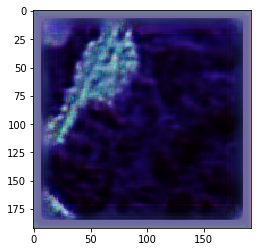

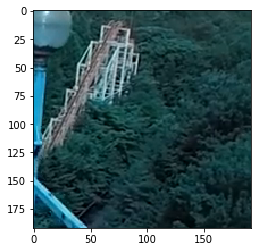

int64


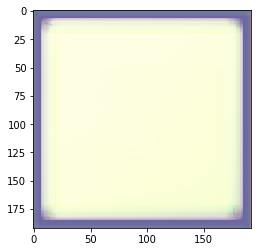

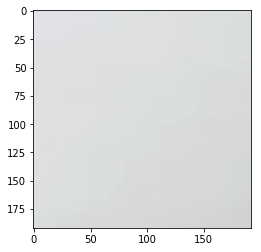

int64


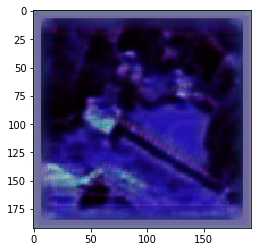

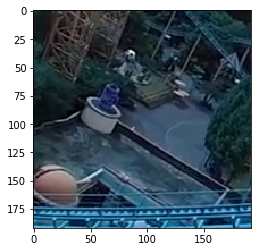

int64


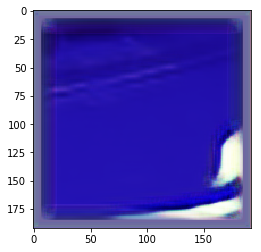

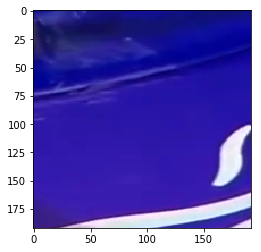

int64


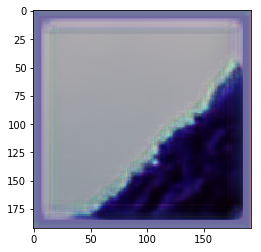

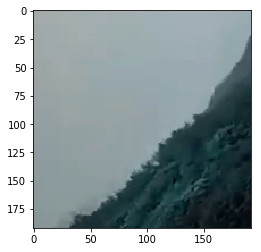

int64


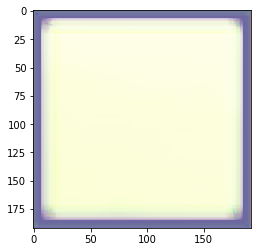

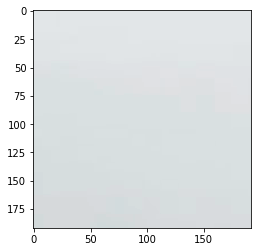

int64


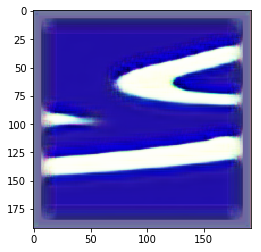

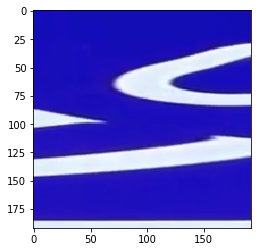

int64


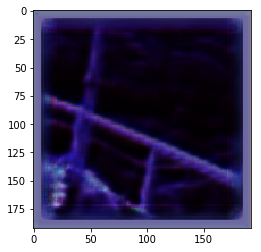

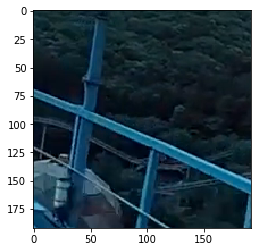

int64


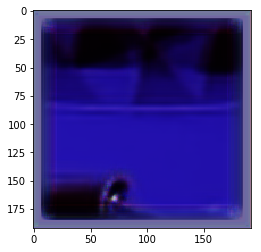

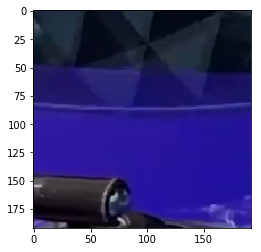

int64


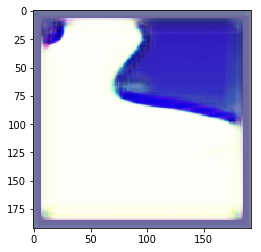

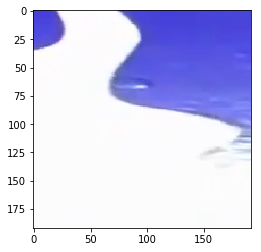

int64


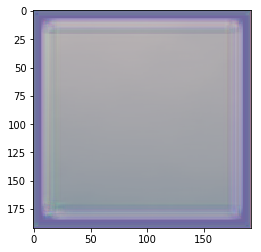

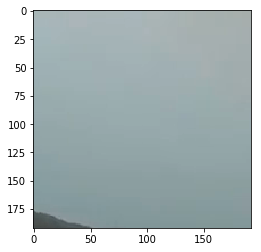

int64


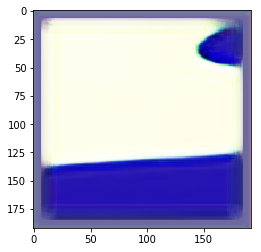

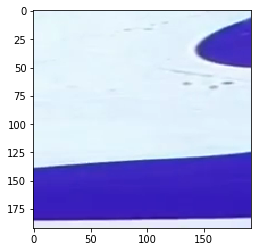

int64


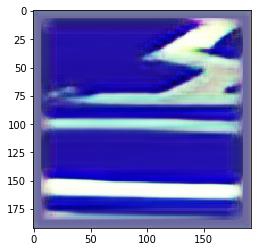

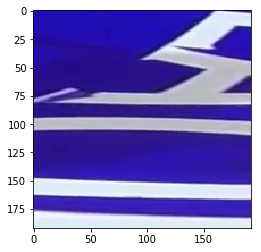

int64


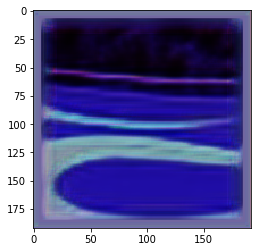

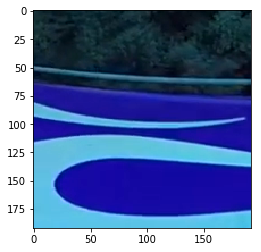

int64


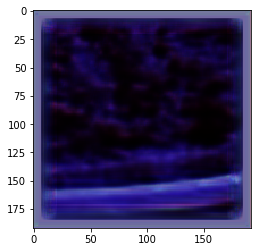

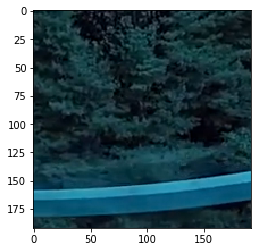

int64


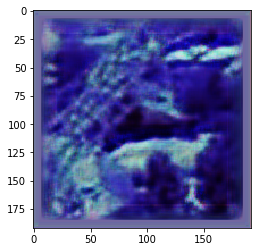

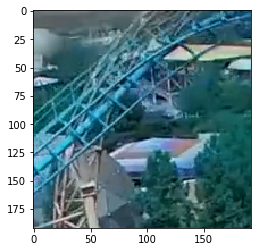

int64


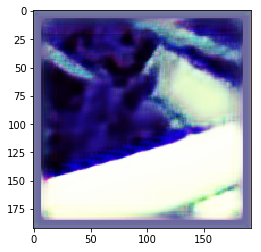

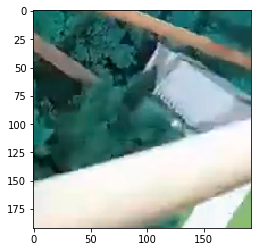

int64


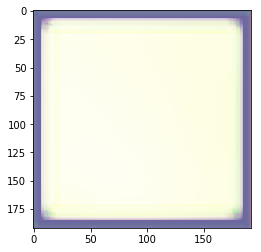

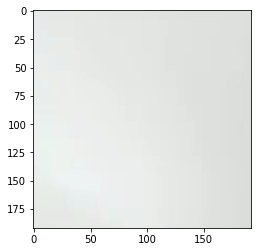

int64


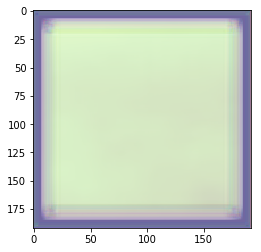

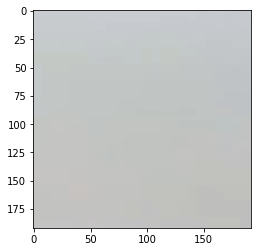

int64


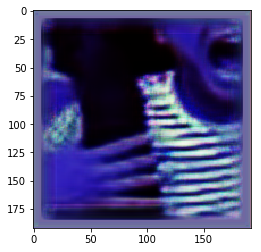

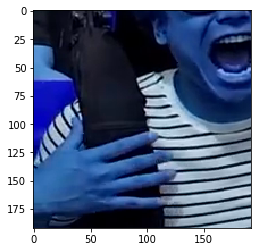

int64


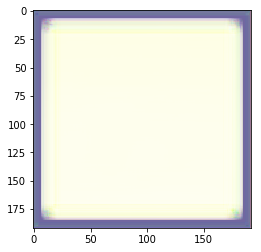

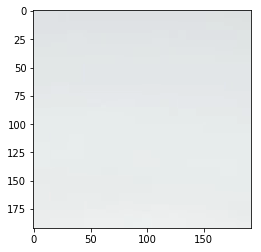

KeyboardInterrupt: 

In [71]:
import time
for i in range(100):
    x = myGenerator(1)
    xtest, ytest = next(x)
    #print('xtrain shape:',xtest.shape)
    #print('ytrain shape:',ytest.shape)
    pred = cgan.generator.predict(xtest)
    pred = pred*127.5 + 127.5
    pred = pred.astype(int)
    print(pred.dtype)
    plt.imshow(pred[0])
    plt.show()
    ytest = ytest*127.5+127.5
    ytest = ytest.astype(int)
    plt.imshow(ytest[0])
    plt.show()
    #break
    #time.sleep(1)

In [34]:
pred = cgan.generator.predict(xtest)
print(pred[0])

[[[-0.3483339  -0.13816969  0.13200115]
  [-0.31992564  0.27835593  0.20599014]
  [-0.20541836  0.7820955   0.07106535]
  ...
  [-0.20541836  0.7820955   0.07106535]
  [-0.32300898  0.32719958 -0.2834047 ]
  [-0.35141724 -0.08932595 -0.2834047 ]]

 [[-0.19001254 -0.39552227 -0.2834047 ]
  [-0.3457319   0.41273296 -0.2834047 ]
  [-0.42066342  0.8290211  -0.2834047 ]
  ...
  [-0.42066342  0.8290211  -0.2834047 ]
  [-0.42066342  0.63147783 -0.2834047 ]
  [-0.42066342 -0.1767774  -0.2834047 ]]

 [[-0.42066342 -0.41174242 -0.2834047 ]
  [-0.35211566  0.08571076 -0.2834047 ]
  [-0.42066342 -0.18308946 -0.2834047 ]
  ...
  [-0.42066342 -0.18308946 -0.2834047 ]
  [-0.4070527  -0.3644126  -0.21881926]
  [-0.42066342 -0.4697713  -0.11666389]]

 ...

 [[-0.42066342 -0.41174242 -0.2834047 ]
  [-0.35211566  0.08571076 -0.2834047 ]
  [-0.42066342 -0.18308946 -0.2834047 ]
  ...
  [-0.42066342 -0.18308946 -0.2834047 ]
  [-0.4070527  -0.3644126  -0.21881926]
  [-0.42066342 -0.4697713  -0.11666389]]

 [